# Sistema de recomendacion - cultivos CIP

### Librerias

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import mysql.connector
import os
from datetime import datetime, timedelta

## 1. Cargar datos
### 1.1 Datos de envios historicos al mundo

In [6]:
send_clones_historical = pd.read_csv("by_accesion.csv")
send_clones_historical

,Order Request ID,Request Number,Crop,Consignee Country,State,City,Accession number,DOI,Date of Request,Date of Cancelled,...,Purpose,Biological Status,Biological Status CIP,Custody in Charge,Genebank Accession Status,MLS Status,Labcode / LOTID,order_request_item_id,Brief description of use of the germplasm,Notes and Comments for the request
0,1,1989172,Potato,Rwanda,NaN,NaN,CIP 800990,NaN,23/01/1990,NaN,...,NaN,400,BredLine,Noelle Anglin,NA-Inactive,0,NaN,4485,NaN,NaN
1,1,1990004,Potato,Canada,Quebec,Quebec,CIP 384111.23,10.18730/18X496,23/01/1990,NaN,...,NaN,400,BredLine,Noelle Anglin,NA-Inactive,1,NaN,96835,NaN,NaN
2,1,1990004,Potato,Canada,Quebec,Quebec,CIP 384142.25,10.18730/18X4HE,23/01/1990,NaN,...,NaN,400,BredLine,Noelle Anglin,NA-Inactive,1,NaN,96836,NaN,NaN
3,1,1990004,Potato,Canada,Quebec,Quebec,CIP 385058.17,10.18730/18X4ZW,23/01/1990,NaN,...,NaN,400,BredLine,Noelle Anglin,NA-Active,99,NaN,96837,NaN,NaN
4,1,1990004,Potato,Canada,Quebec,Quebec,CIP 389429.31,10.18730/18X8BS,23/01/1990,NaN,...,NaN,400,AdvBred,Noelle Anglin,NA-Active,1,NaN,97069,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22605,1,2023124,Potato,Peru,NaN,Lima,CIP 398017.53,10.18730/18XG9M,15/09/2023,NaN,...,Breeding,400,AdvBred,Noelle Anglin,NA-Active,99,NaN,584526,Obtener tubérculos para ser utilizados en un p...,"ABT: 1481-USAI, 1481-1004, 1481-1004-10"
22606,1,2023124,Potato,Peru,NaN,Lima,CIP 398180.289,10.18730/V9R1R,15/09/2023,NaN,...,Breeding,400,AdvBred,Noelle Anglin,NA-Active,99,NaN,584529,Obtener tubérculos para ser utilizados en un p...,"ABT: 1481-USAI, 1481-1004, 1481-1004-10"
22607,1,2023124,Potato,Peru,NaN,Lima,CIP 398208.219,10.18730/V9R7Y,15/09/2023,NaN,...,Breeding,400,AdvBred,Noelle Anglin,NA-Active,99,NaN,584527,Obtener tubérculos para ser utilizados en un p...,"ABT: 1481-USAI, 1481-1004, 1481-1004-10"
22608,1,2023127,Potato,Peru,Lima,Lima,CIP 312721.245,10.18730/V9PWR,18/09/2023,NaN,...,Breeding,400,BredLine,Noelle Anglin,NA-Active,99,NaN,584631,Se entregarán las plántulas invitro a los sigu...,ABT: 1481-USAI 1481-1003 1481-1003-10


In [ ]:
select_col_sch = ['Request Number', 'Crop', 'Consignee Country','Accession number', 'Date of Distribution', 'Quantity',
       'Form Material', 'Institution', 'Category of Institution','Distribution to the User', 'Purpose', 'Biological Status',
       'Biological Status CIP']

In [33]:
send_clones_historical_filter =  send_clones_historical[select_col_sch]
send_clones_historical_filter[['CIP', 'Family', 'Clone']] = send_clones_historical_filter['Accession number'].str.extract(r' ?(CIP) ?(\d+)(?:\.(\d+))?')
send_clones_historical_filter

/tmp/ipykernel_14244/502490476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  send_clones_historical_filter[['CIP', 'Family', 'Clone']] = send_clones_historical_filter['Accession number'].str.extract(r' ?(CIP) ?(\d+)(?:\.(\d+))?')
/tmp/ipykernel_14244/502490476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  send_clones_historical_filter[['CIP', 'Family', 'Clone']] = send_clones_historical_filter['Accession number'].str.extract(r' ?(CIP) ?(\d+)(?:\.(\d+))?')
/tmp/ipykernel_14244/502490476.py:2: Set

,Request Number,Crop,Consignee Country,Accession number,Date of Distribution,Quantity,Form Material,Institution,Category of Institution,Distribution to the User,Purpose,Biological Status,Biological Status CIP,CIP,Family,Clone
0,1989172,Potato,Rwanda,CIP 800990,23/01/1990,2,In-vitro,PNAP - ISAR,National Agric. Research (NARS),"External, International",NaN,400,BredLine,CIP,800990,NaN
1,1990004,Potato,Canada,CIP 384111.23,23/01/1990,200,Seed,PROGEST,Commercial Sector,"Internal, International",NaN,400,BredLine,CIP,384111,23
2,1990004,Potato,Canada,CIP 384142.25,23/01/1990,200,Seed,PROGEST,Commercial Sector,"Internal, International",NaN,400,BredLine,CIP,384142,25
3,1990004,Potato,Canada,CIP 385058.17,23/01/1990,200,Seed,PROGEST,Commercial Sector,"Internal, International",NaN,400,BredLine,CIP,385058,17
4,1990004,Potato,Canada,CIP 389429.31,23/01/1990,200,Seed,PROGEST,Commercial Sector,"Internal, International",NaN,400,AdvBred,CIP,389429,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22605,2023124,Potato,Peru,CIP 398017.53,20/11/2023,10,In-vitro,International Potato Center - CIP,CGIAR Centers,"Internal, CIPHQ Breeders and Researchers",Breeding,400,AdvBred,CIP,398017,53
22606,2023124,Potato,Peru,CIP 398180.289,20/11/2023,10,In-vitro,International Potato Center - CIP,CGIAR Centers,"Internal, CIPHQ Breeders and Researchers",Breeding,400,AdvBred,CIP,398180,289
22607,2023124,Potato,Peru,CIP 398208.219,20/11/2023,10,In-vitro,International Potato Center - CIP,CGIAR Centers,"Internal, CIPHQ Breeders and Researchers",Breeding,400,AdvBred,CIP,398208,219
22608,2023127,Potato,Peru,CIP 312721.245,12/12/2023,200,In-vitro,International Potato Center - CIP,CGIAR Centers,"Internal, CIPHQ Breeders and Researchers",Breeding,400,BredLine,CIP,312721,245


### 1.2 Analisis exploratorio de datos

In [11]:
print(send_clones_historical_filter.groupby('Quantity').size())
print(send_clones_historical_filter.groupby('Form Material').size())
print(send_clones_historical_filter.groupby('Category of Institution').size())
print(send_clones_historical_filter.groupby('Distribution to the User').size())
print(send_clones_historical_filter.groupby('Purpose').size())
print(send_clones_historical_filter.groupby('Biological Status').size())
print(send_clones_historical_filter.groupby('Biological Status CIP').size())

Quantity
1         97
2       4096
3        329
4       7515
5       1264
        ... 
540        2
600        5
800        8
1000       1
1500       7
Length: 64, dtype: int64
Form Material
In-vitro    21839
Seed          771
dtype: int64
Category of Institution
Advance research Institute (ARI)        332
CGIAR Centers                         10781
CIP Genebank                            560
Commercial Sector                       442
Farmer                                   11
Individual/Unknown                      226
International Genebank                   61
National Agric. Research (NARS)        7853
No Governmental Organization (NGO)      326
University                             2013
dtype: int64
Distribution to the User
External, International                     10338
External, National                            838
Internal, CIPHQ Breeders and Researchers     9509
Internal, International                      1904
Internal, National (CIP Stations)              21
dtype: i

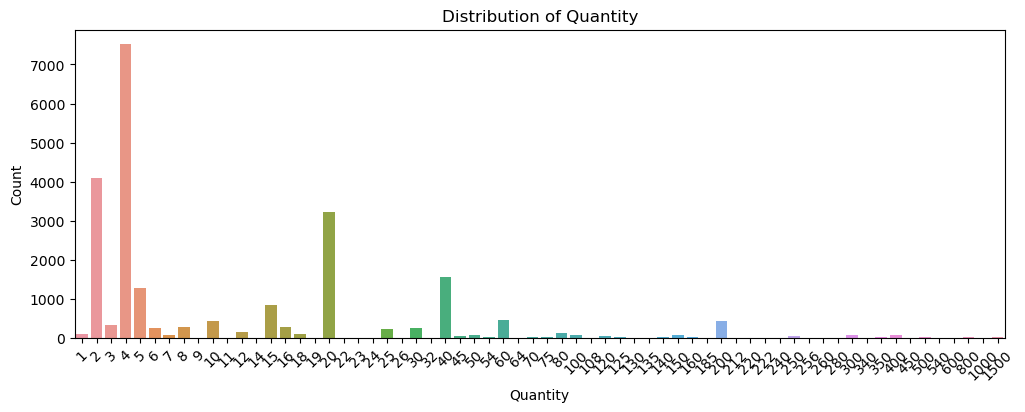

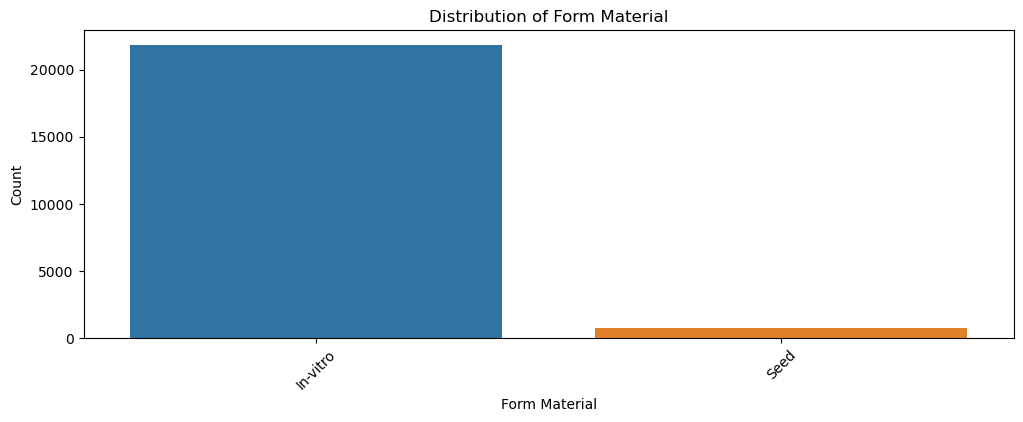

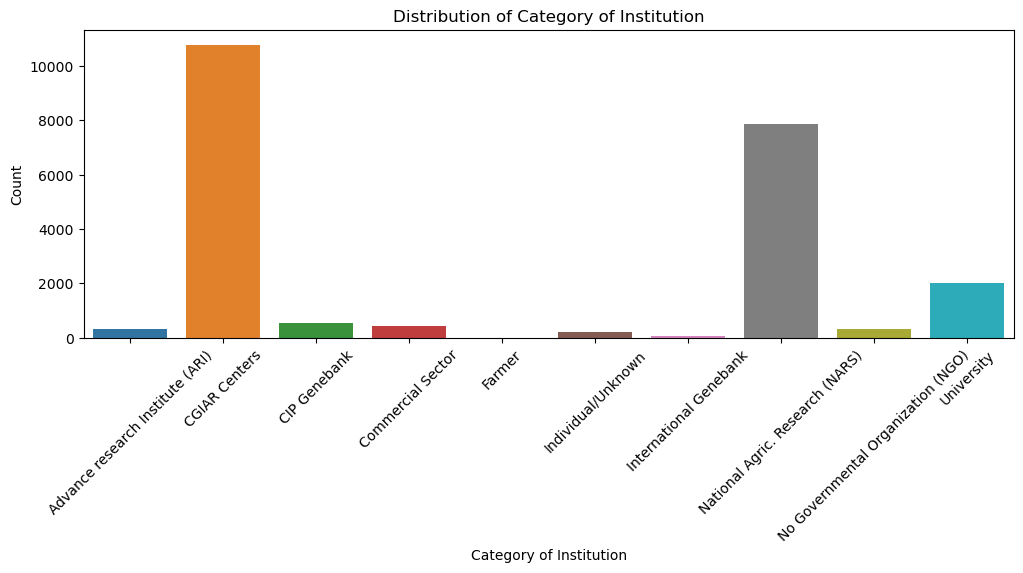

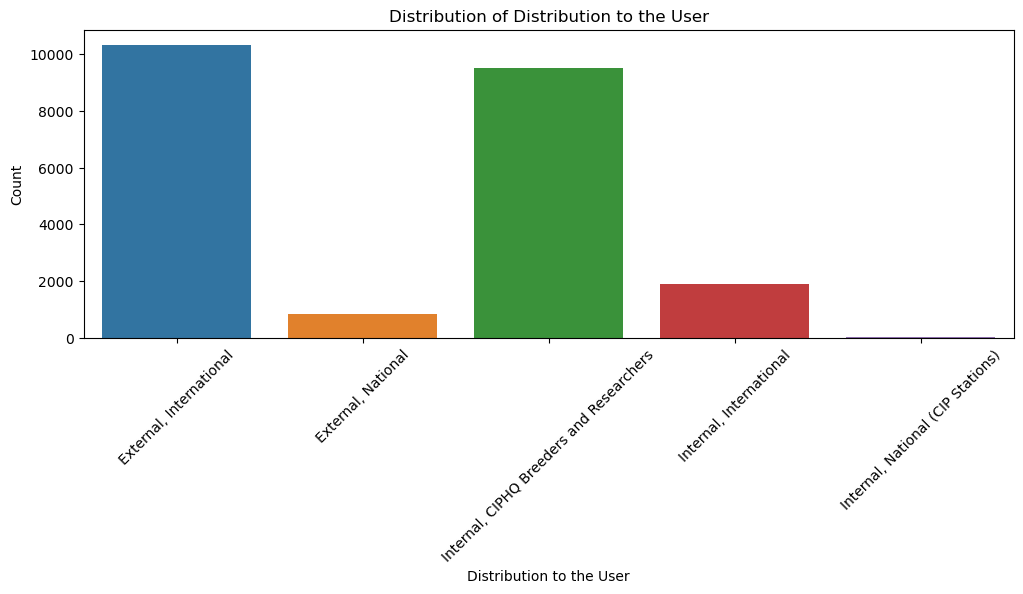

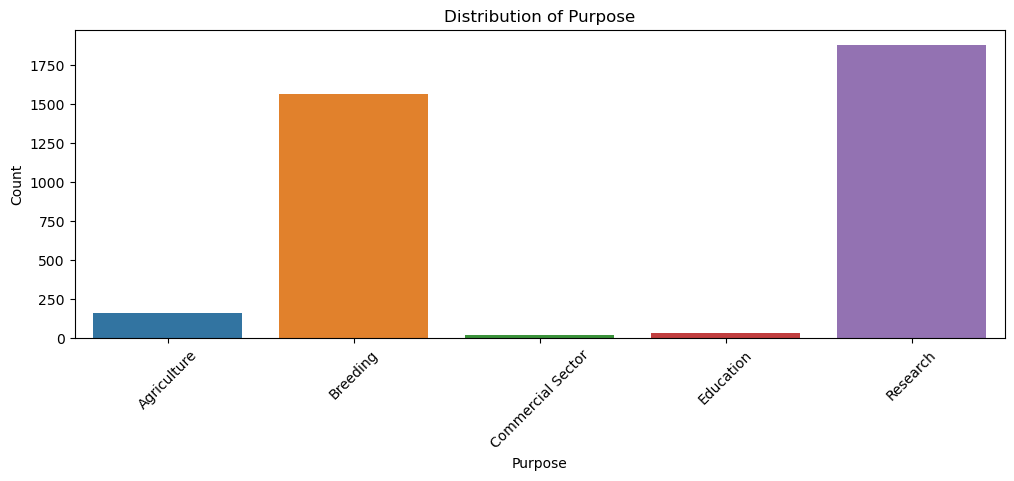

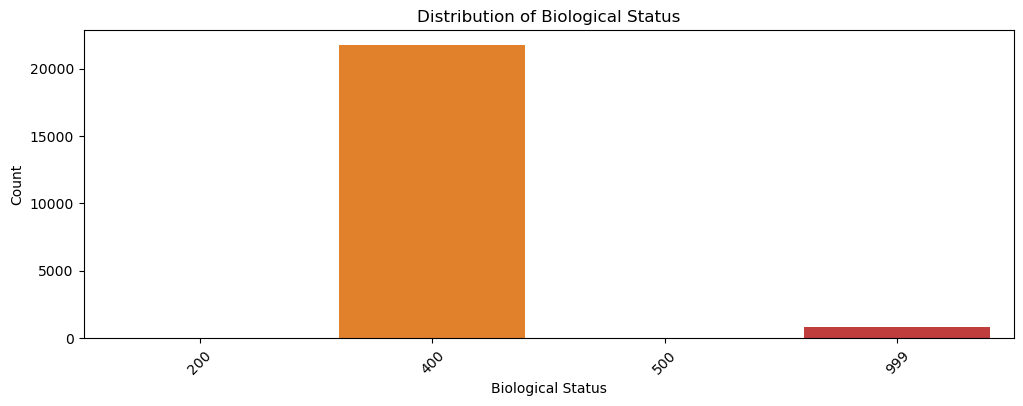

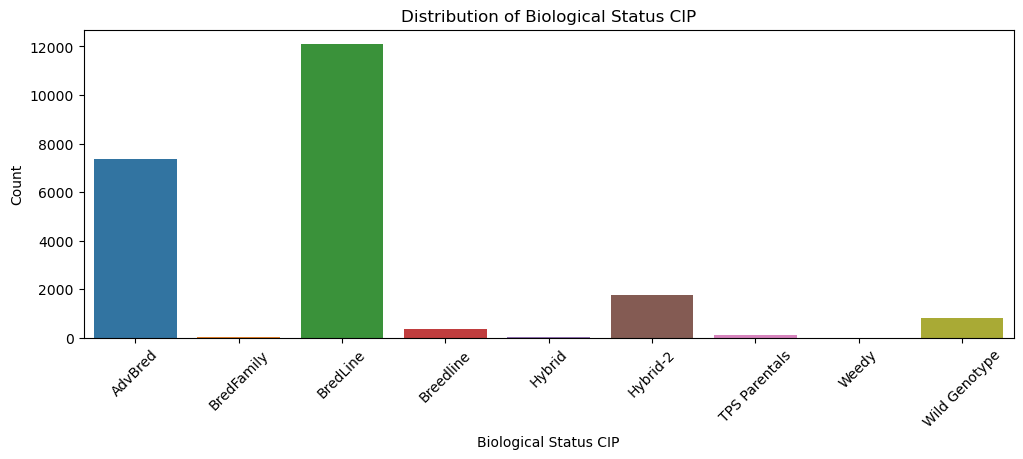

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Función para crear y mostrar gráficos de barras
def plot_grouped_data(dataframe, column_name):
    grouped_data = dataframe.groupby(column_name).size().reset_index(name='Count')
    plt.figure(figsize=(12, 4))
    sns.barplot(x=column_name, y='Count', data=grouped_data)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {column_name}')
    plt.show()

# Lista de las columnas a graficar
columns = [
    'Quantity',
    'Form Material',
    'Category of Institution',
    'Distribution to the User',
    'Purpose',
    'Biological Status',
    'Biological Status CIP'
]

# Graficando cada columna
for column in columns:
    plot_grouped_data(send_clones_historical_filter, column)


### 1.3 Clones exitosos considerados variedades en diferentes paises

In [15]:
varieties_realease = pd.read_csv('Variedades.csv')
select_col_vr= ['Accession number', 'Continent', 'Country', 'Accession name',
       'Year of cross ', 'Year of release','Corporative Data Base (Clon) ', 'Corporative Data Base(Fam) ',
       'Invitro', 'Population', 'Catalogue', 'Organization']
varieties_realease = varieties_realease[select_col_vr]

In [17]:
varieties_realease[['CIP', 'Family', 'Clone']] = varieties_realease['Accession number'].str.extract(r' ?(CIP) ?(\d+)(?:\.(\d+))?')

In [18]:
varieties_realease

,Accession number,Continent,Country,Accession name,Year of cross,Year of release,Corporative Data Base (Clon),Corporative Data Base(Fam),Invitro,Population,Catalogue,Organization,CIP,Family,Clone
0,CIP279139.5,LAC,Peru,Santa Ana,1979,--,YES,YES,YES,NaN,YES,NaN,CIP,279139,5
1,CIP279142.12,LAC,Peru,Maria Huanca,1979,1987,YES,YES,YES,NaN,YES,NaN,CIP,279142,12
2,CIP304371.67,ASIA,Bangladesh,BARI Alu-87,2004,2019,YES,YES,YES,LTVR,NO,NaN,CIP,304371,67
3,CIP370120,ASIA,Indonesia,Fries,1970,2003,YES,YES,YES,---,YES,NaN,CIP,370120,NaN
4,CIP371056.175,SSA,Angola,Boa Branca,1971,1993,NO,NO,NO,--,NO,NaN,CIP,371056,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,CIP398211.35,LAC,Peru,Musuq Tomasa,1998,--,YES,YES,YES,NaN,YES,NaN,CIP,398211,35
195,CIP399049.22,LAC,Peru,Poderosa,1999,2017,YES,YES,YES,B1C5,YES,NaN,CIP,399049,22
196,CIP399062.118,LAC,Peru,Kawsay,1999,2017,YES,YES,YES,B1C5,YES,NaN,CIP,399062,118
197,CIP399075.7,LAC,Peru,Puca Lliclla INIA 312,1999,2007,YES,YES,YES,B1C5,YES,NaN,CIP,399075,7


In [ ]:
#varieties_realease.to_csv('varieties_sql.csv', index=False)

In [19]:
exito = {}
for country in varieties_realease['Country'].unique():
    successful_varieties = varieties_realease[varieties_realease['Country'] == country]['Accession number'].tolist()
    cleaned_varieties = ['CIP ' + code.split('CIP')[1].strip() if 'CIP' in code else code for code in successful_varieties]
    # Asignar la lista limpia al diccionario de éxito
    exito[country] = cleaned_varieties

In [48]:
exito.get('Colombia')

['CIP 379055.1', 'CIP 390663.8']

## Score value para medir exito de clones

In [53]:
df = send_clones_historical_filter
df['Exito'] = df.apply(lambda row: row['Accession number'] in exito.get(row['Consignee Country'], []), axis=1)

columns = [
    'Quantity',
    'Form Material',
    'Category of Institution',
    'Distribution to the User',
    'Purpose',
    'Biological Status',
    'Biological Status CIP'
]

# Calcular un score basado en varios factores enfocado en consumo o mejoramiento
def calcular_score(row):
    score = 0
    if row['Exito']:
        score += 10
    score += row['Quantity'] / 100
    
    if row['Form Material'] == 'seed':
        score += 2
    else:
        score += 1
        
    if row['Purpose'] == 'Commercial Sector':
        score += 5
    elif row['Purpose'] == 'Agriculture':
        score += 4
    elif row['Purpose'] == 'Breeding':
        score += 3
    else:
        score += 1

    return score

 
df['Score'] = df.apply(calcular_score, axis=1)

# Matriz dispersa 
score_table = df.pivot_table(index='Family', columns='Consignee Country', values='Score', aggfunc='mean', fill_value=0)

print(score_table)

/tmp/ipykernel_14244/3855481218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Exito'] = df.apply(lambda row: row['Accession number'] in exito.get(row['Consignee Country'], []), axis=1)
/tmp/ipykernel_14244/3855481218.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Score'] = df.apply(calcular_score, axis=1)


Consignee Country  Afghanistan  Algeria  Angola  Argentina  Armenia  \
Family                                                                
278072                     0.0      0.0     0.0        0.0      0.0   
278096                     0.0      0.0     0.0        0.0      0.0   
279023                     0.0      0.0     0.0        0.0      0.0   
280054                     0.0      0.0     0.0        0.0      0.0   
280090                     0.0      0.0     0.0        0.0      0.0   
...                        ...      ...     ...        ...      ...   
814002                     0.0      0.0     0.0        0.0      0.0   
814003                     0.0      0.0     0.0        0.0      0.0   
814004                     0.0      0.0     0.0        0.0      0.0   
819001                     0.0      0.0     0.0        0.0      0.0   
819002                     0.0      0.0     0.0        0.0      0.0   

Consignee Country  Australia  Austria  Bahamas  Bangladesh  Belarus  ...  \


/home/fascue/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


1.2304489213782739


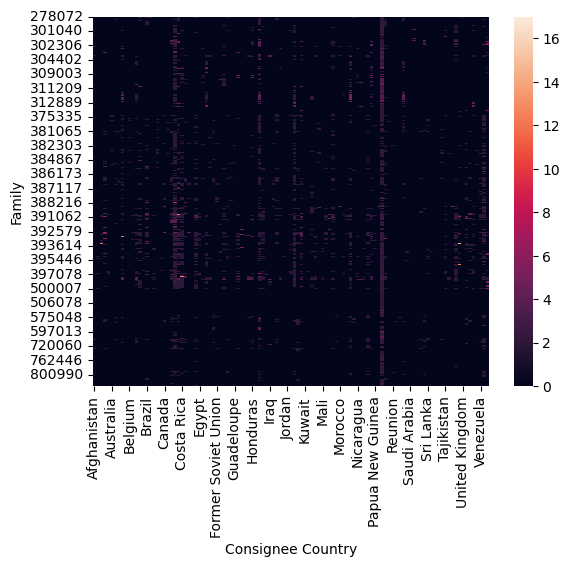

In [54]:
max_value = np.max(score_table)
print(max_value)
sns.heatmap(score_table)
plt.show()

### Descomposicion de matrices (SVD - Single Value Descomposition)

In [55]:
### Conservar nombres de columnas y files - 

index_names = score_table.index  # Nombres de filas
column_names = score_table.columns  # Nombres de columnas

# Manejo de valores faltantes (media)
df_filled = score_table.fillna(score_table.mean())

### Convertir a flotantes
matrix = df_filled.values.astype(float)

## Normalizar tabla de entrada
### media de matriz
mean = np.mean(matrix, axis=0)
### Desviacion standar
std_dev = np.std(matrix, axis=0)
#### Matriz normalizada
R_normalized = (matrix - mean) / std_dev

# Aplica SVD
try:
    U, sigma, VT = np.linalg.svd(R_normalized, full_matrices=False)
    print("SVD exitoso!")
    sigma_matrix = np.diag(sigma)
    reconstructed_matrix = U @ sigma_matrix @ VT
    reconstructed_df = pd.DataFrame(reconstructed_matrix, index=index_names, columns=column_names)
    print(reconstructed_df)

except np.linalg.LinAlgError as e:
    print("Error en SVD:", e)
except np.linalg.LinAlgError as e:
    print("Error en SVD:", e)



SVD exitoso!
Consignee Country  Afghanistan   Algeria    Angola  Argentina   Armenia  \
Family                                                                    
278072               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
278096               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
279023               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
280054               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
280090               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
...                        ...       ...       ...        ...       ...   
814002               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
814003               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
814004               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
819001               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   
819002               -0.107754 -0.097023 -0.079555   -0.27793 -0.089184   

Consignee C

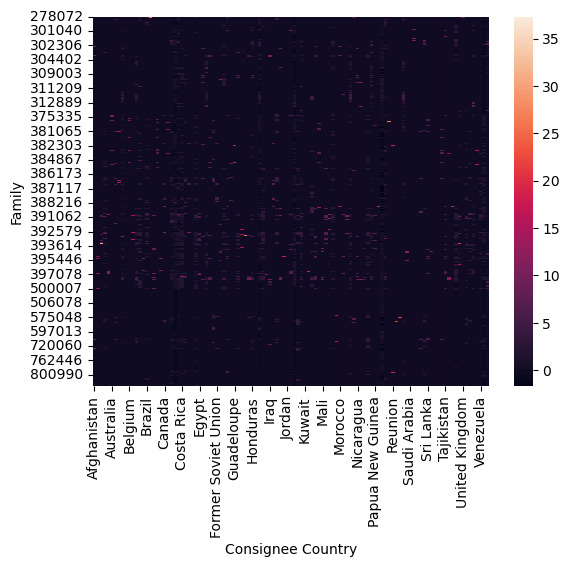

In [56]:
sns.heatmap(reconstructed_df)
plt.show()

### Rescalamos la matriz a valores de 0 a 5

In [57]:
scaler = MinMaxScaler()
scaled_values = pd.DataFrame(scaler.fit_transform(reconstructed_df), columns=reconstructed_df.columns)*5
scaled_values.index = reconstructed_df.index

In [63]:
scaled_values.shape

(1394, 113)

#### Exportamos la matriz a una tabla de 3 columnas

In [60]:
family = scaled_values.index.tolist()
values = scaled_values.values.flatten().tolist()
countries = scaled_values.columns.tolist()

family_repeated = []
values_repeated = []
countries_repeated = []

for idx, fam in enumerate(family):
    for col_idx, country in enumerate(countries):
        family_repeated.append(fam)
        values_repeated.append(values[idx * len(countries) + col_idx])
        countries_repeated.append(country)

df = pd.DataFrame({
    'Family': family_repeated,
    'Value': values_repeated,
    'Country': countries_repeated
})

In [64]:
df.to_csv('df_sql.csv', index=False) ### exporta a base de datos

In [69]:
df

,Family,Value,Country
0,278072,7.684825e-15,Afghanistan
1,278072,2.550044e-15,Algeria
2,278072,1.669671e-15,Angola
3,278072,0.000000e+00,Argentina
4,278072,7.884318e-15,Armenia
...,...,...,...
157517,819002,2.279427e-14,Uzbekistan
157518,819002,2.377439e-14,Vanuatu
157519,819002,1.616762e-14,Venezuela
157520,819002,5.134781e-14,Vietnam


### Para reestructura la matriz de dispersa 

In [71]:
df_reestructurado = pd.pivot_table(df, values='Value', index='Family', columns='Country', aggfunc='first')

In [73]:
df_reestructurado

Country,Afghanistan,Algeria,Angola,Argentina,Armenia,Australia,Austria,Bahamas,Bangladesh,Belarus,...,Turkey,Uganda,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Zimbabwe
Family,,,,,,,,,,,,,,,,,,,,,
278072,7.684825e-15,2.550044e-15,1.669671e-15,0.000000e+00,7.884318e-15,2.449430e-14,3.740741e+00,5.000000e+00,5.984796e-15,2.105087e-14,...,5.988265e-14,1.251603e-14,7.190862e-14,2.400857e-14,6.002143e-15,0.000000e+00,2.582136e-14,2.020000e+00,4.149459e-14,3.344371e+00
278096,5.620504e-15,1.047773e-14,1.179612e-15,1.224715e-14,2.977653e-14,1.396452e-14,3.740741e+00,0.000000e+00,6.331741e-15,1.365227e-14,...,6.376843e-14,9.159340e-15,7.278032e-14,1.984524e-14,1.006140e-15,3.365364e-14,2.403893e-14,3.731390e-14,3.941292e-14,0.000000e+00
279023,3.877107e-15,9.818535e-15,2.229120e-15,1.311451e-14,1.821460e-14,9.081277e-15,1.693090e-14,8.847090e-15,6.210310e-15,1.284563e-14,...,2.393918e-14,2.488895e-14,4.208333e+00,3.053113e-14,1.460637e-14,2.338407e-14,2.391750e-14,2.994133e-14,5.467848e-14,5.000000e+00
280054,6.522560e-15,1.095478e-14,1.075529e-15,1.276756e-14,8.743006e-15,2.244732e-14,2.293304e-14,1.046038e-14,1.214306e-16,6.279699e-14,...,2.331468e-14,1.317522e-14,4.208333e+00,5.669076e-14,4.010681e-14,3.441691e-14,2.324096e-14,4.614364e-15,5.329071e-14,8.014422e-15
280090,4.631712e-15,9.480264e-15,3.599551e-15,1.082467e-14,9.506285e-15,1.052977e-14,2.126771e-14,8.339683e-15,1.760744e-14,1.281961e-14,...,6.564194e-14,1.206934e-14,7.316196e-14,2.020000e+00,3.677614e-14,3.736594e-14,2.426011e-14,1.356554e-14,5.433154e-14,2.144118e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814002,4.926615e-15,8.821069e-15,2.422108e-15,1.356554e-14,8.604228e-15,1.015681e-14,2.329734e-14,8.504482e-15,5.707240e-15,9.532306e-15,...,2.636780e-14,1.225148e-14,7.438928e-14,2.383510e-14,1.817990e-14,2.189221e-14,2.411699e-14,1.644518e-14,5.148659e-14,1.859624e-14
814003,4.874573e-15,8.873111e-15,2.630274e-15,1.228184e-14,9.358833e-15,1.045171e-14,2.341877e-14,8.517492e-15,5.707240e-15,1.041701e-14,...,2.532696e-14,1.219511e-14,7.420713e-14,2.348816e-14,1.814521e-14,2.178813e-14,2.393918e-14,1.693090e-14,5.148659e-14,1.852685e-14
814004,4.917941e-15,8.578208e-15,2.513181e-15,1.314920e-14,8.873111e-15,1.024354e-14,2.334938e-14,8.391725e-15,5.308254e-15,9.341486e-15,...,2.671474e-14,1.218210e-14,7.442397e-14,2.386980e-14,1.800643e-14,2.213507e-14,2.410832e-14,1.679212e-14,5.141720e-14,1.863093e-14


In [78]:
def load_data_from_mysql():
    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="123a456",
        database="foreslab_catalogue"
    )

    query = "SELECT * FROM `recommendations`"
    cursor = mydb.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()

    df = pd.DataFrame(rows, columns=['id', 'Family', 'valor', 'Country','time1','time2'])
    df_reestructurado = pd.pivot_table(df, values='valor', index='Family', columns='Country', aggfunc='first')
    cursor.close()
    mydb.close()

    csv_path = 'reconstructed_df.csv'
    df_reestructurado.to_csv(csv_path, index=True)
    return df_reestructurado


def get_recommendations(column_name, reconstructed_df, top_n=5):
    column_idx = reconstructed_df.columns.get_loc(column_name)
    item_similarity = cosine_similarity(reconstructed_df.T)
    column_similarities = item_similarity[column_idx]
    similar_indices = column_similarities.argsort()[::-1][1:top_n+1]
    recommended_rows = reconstructed_df.index[similar_indices]
    return recommended_rows

In [79]:
reconstructed_df = load_data_from_mysql()

In [86]:
get_recommendations('Peru',reconstructed_df,5)

Index([288787, 301045, 300137, 302086, 302476], dtype='int64', name='Family')

### Datos de los clones Caracterizados

In [90]:
clones_charaterization = pd.read_csv('clones_caracteristicas.csv')
columnas_vacias = clones_charaterization.columns[clones_charaterization.isnull().all()].tolist()

In [91]:
umbral = 0.2
porcentaje_nulos = clones_charaterization.isnull().mean()
columnas_a_eliminar = porcentaje_nulos[porcentaje_nulos > umbral].index
clones_charaterization_f = clones_charaterization.drop(columns=columnas_a_eliminar)

In [92]:
clones_charaterization_f.columns
clones_charaterization_f[['CIP', 'Family', 'Clone']] = clones_charaterization_f['Accession number'].str.extract(r' ?(CIP) ?(\d+)(?:\.(\d+))?')
clones_charaterization_f

,Ord,Accession number,Catalogue,Population Group,Parent Female,Parent Male,Predominant tuber skin color,Tuber skin secondary color,Distribution of secondary tuber skin color,Predominant tuber flesh color,...,Tuber shape depth of eyes,Late blight (LB),Potato virus Y (PVY),Tuber yield (Kg/plants),Dry matter (%),Chipping color,Adaptability,CIP,Family,Clone
0,1,CIP300046.22,LTVR,LTVR,CIP392973.48 (95.048),CIP393613.2 (TXY.2),1,0,0,2,...,3,R,R,0.98,21.00,3.0,TAB,CIP,300046,22
1,2,CIP300048.12,LTVR,LTVR,CIP392973.48 (95.048),CIP392820.1 (C93.154),1,0,0,2,...,3,HS,S,0.58,21.00,3.0,TAB,CIP,300048,12
2,3,CIP300054.29,LTVR,LTVR,95.059,CIP392820.1 (C93.154),5,0,0,2,...,3,S,ER,0.76,21.00,4.0,TA,CIP,300054,29
3,4,CIP300055.32,LTVR,LTVR,95.071,CIP393613.2 (TXY.2),1,0,0,2,...,3,MS,ER,0.64,16.00,3.0,TAB,CIP,300055,32
4,5,CIP300056.33,LTVR,LTVR,95.071,CIP387170.9,1,6,3,2,...,5,MR,ER,0.72,20.00,2.0,TAB,CIP,300056,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,538,CIP312914.053,,LBHT x LTVR,CIP398208.67,CIP304350.118,5,0,0,2,...,3,R,,NaN,21.40,3.0,,CIP,312914,053
538,539,CIP312915.141,,LBHT x LTVR,CIP398208.704,CIP304350.118,1,5,0,2,...,3,R,,NaN,22.26,4.0,,CIP,312915,141
539,540,CIP312923.058,,LBHT x LTVR,CIP398201.51,CIP304372.7,5,0,0,2,...,3,R,ER,NaN,21.87,3.0,,CIP,312923,058
540,541,CIP312925.105,,LBHT x LTVR,CIP398208.219,CIP304372.7,1,0,0,2,...,3,R,,NaN,23.85,3.0,,CIP,312925,105


In [ ]:
#Export para base de datos
clones_charaterization_f.to_csv('clones_characteristics.csv', index=False)

#### Procesamiento de datos en Linux

```bash
    find . -iname "*jpg" | sed "s/\//,/g" > fotos.csv
    sed "s/_/,/g" fotos.csv > fotos2.csv
```

In [93]:
photo = pd.read_csv('fotos2.csv')

In [94]:
photo[['CIP', 'Family', 'Clone']] = photo['Accession number'].str.extract(r' ?(CIP) ?(\d+)(?:\.(\d+))?')

In [96]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import mysql.connector

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="123a456",
    database="foreslab_catalogue"
)

query = "SELECT id,family,clone_number FROM `clones`"
cursor = mydb.cursor()
cursor.execute(query)
rows = cursor.fetchall()
cursor.close()
mydb.close()

In [97]:
df_clones = pd.DataFrame(rows, columns=['id', 'Family', 'clone_number'])

In [99]:
df_clones['Accession number'] = 'CIP' + df_clones['Family'].astype(str) +'.'+ df_clones['clone_number'].astype(str)


In [102]:
merged_df = pd.merge(photo, df_clones, on='Accession number', how='inner')

In [103]:
merged_df

,co,Accession number,photo,Unnamed: 3,CIP,Family_x,Clone,id,Family_y,clone_number
0,471,CIP399101.1,CIP399101.1 C99.551 2020 (2).JPG,NaN,CIP,399101,1,752,399101,1
1,471,CIP399101.1,CIP399101.1 C99.551 2020 (1).JPG,NaN,CIP,399101,1,752,399101,1
2,478,CIP308474.153,CIP308474.153 (4).JPG,NaN,CIP,308474,153,759,308474,153
3,478,CIP308474.153,CIP308474.153 (2).JPG,NaN,CIP,308474,153,759,308474,153
4,478,CIP308474.153,CIP308474.153 (3).JPG,NaN,CIP,308474,153,759,308474,153
...,...,...,...,...,...,...,...,...,...,...
2239,258,CIP394600.52,394600.52 (3).jpg,NaN,CIP,394600,52,536,394600,52
2240,163,CIP385558.2,385558.2.jpg,NaN,CIP,385558,2,441,385558,2
2241,163,CIP385558.2,385558.2 (4).jpg,NaN,CIP,385558,2,441,385558,2
2242,163,CIP385558.2,385558.2 (2).jpg,NaN,CIP,385558,2,441,385558,2


In [104]:
export = merged_df[['photo','co','Accession number','id']]

In [106]:
export['ruta'] = export['co'].astype(str) +'_'+ export['Accession number'].astype(str)  +'/'+ export['photo'].astype(str)

/tmp/ipykernel_14244/3155444873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export['ruta'] = export['co'].astype(str) +'_'+ export['Accession number'].astype(str)  +'/'+ export['photo'].astype(str)


In [109]:
export

,photo,co,Accession number,id,ruta
0,CIP399101.1 C99.551 2020 (2).JPG,471,CIP399101.1,752,471_CIP399101.1/CIP399101.1 C99.551 2020 (2)...
1,CIP399101.1 C99.551 2020 (1).JPG,471,CIP399101.1,752,471_CIP399101.1/CIP399101.1 C99.551 2020 (1)...
2,CIP308474.153 (4).JPG,478,CIP308474.153,759,478_CIP308474.153/CIP308474.153 (4).JPG
3,CIP308474.153 (2).JPG,478,CIP308474.153,759,478_CIP308474.153/CIP308474.153 (2).JPG
4,CIP308474.153 (3).JPG,478,CIP308474.153,759,478_CIP308474.153/CIP308474.153 (3).JPG
...,...,...,...,...,...
2239,394600.52 (3).jpg,258,CIP394600.52,536,258_CIP394600.52/394600.52 (3).jpg
2240,385558.2.jpg,163,CIP385558.2,441,163_CIP385558.2/385558.2.jpg
2241,385558.2 (4).jpg,163,CIP385558.2,441,163_CIP385558.2/385558.2 (4).jpg
2242,385558.2 (2).jpg,163,CIP385558.2,441,163_CIP385558.2/385558.2 (2).jpg


In [111]:
export.to_csv('photos_sql.csv', index=False)